### How genetic algorithm will work

<center><img src="Genetic.jpg" ></center>

import neccessary libarary

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import gc
from sklearn.model_selection import train_test_split
from numpy.random import choice
from matplotlib import pyplot as plt

plot will be shown inside notebook

In [2]:
%matplotlib inline

loading the dataset

In [3]:
dataset = pd.DataFrame.from_csv('featured_data.csv')

In [4]:
train , test = train_test_split(dataset,train_size = 0.65)
validation , test = train_test_split(test,test_size = 0.5)

In [5]:
train.shape

(648, 17792)

In [6]:
test.shape

(175, 17792)

In [7]:
validation.shape

(174, 17792)

genetic algoritm implementation

In [8]:
class genetic:
    def __init__(self,Data,
                Population = 20,
                Generation = 10,
                Penalty_rate = 1.0,
                Mutation_rate_sample = 0.8,
                Mutation_rate_chromosome = 0.8,
                Crossover_rate = 0.7,
                column_label = 'class',
                crossover_type = 'single-point',
                Score_threshhold = 80.0,
                Mutation_decrease = True ):
        """
        Initializing The Parameter Of Algorithm
            Args:
                Data : "Pandas DataFrame" Input dataset
                Label : "Pandas DataFrame" True Label of dataset
                Population : "Integer" number of the individual of society
                Generation : "Integer" Maximum number of generation
                Mutation_rate_sample : "Float" Initial Mutation Rate for sample
                                        it will be different for different
                                        generation
                Mutation_rate_chromosome : "Float" Initial Mutation Rate for gene
                                        it will be different for different
                                        generation
                Crossover_rate : "Float" Rate of applying cross over in population
                
                Penalty_rate : "Float" *Sparcity coeficient , penalty in compute fittnes
                                wich indicate how much we care about sparcity
                                of feature
                crossover_type : "String "How the crossover would effect our Masks
                                "single-point","two-point","uniform"
                                
                Score_threshhold : "Float "When fitness reach this value will break the training
                
                Mutation_decrease : "Boolean "is Mutation rate Decrease over the Generation
        

        """
        self.Data = Data;
        self.Data_train , self.Data_test = train_test_split(self.Data,test_size = 0.22);
        
        self.Label_train = self.Data_train.ix[:,self.Data.columns == column_label];
        self.Label_test  = self.Data_test.ix[:,self.Data.columns == column_label];
        
        self.Data_train = self.Data_train.ix[:,self.Data.columns != column_label];
        self.Data_test = self.Data_test.ix[:,self.Data.columns != column_label];
        
        self.chromosome_shape = self.Data_train.shape[1];
        self.Population = Population;
        self.Generation = Generation;
        self.current_generation = 0;
        self.Mutation_rate_sample = Mutation_rate_sample;
        self.Mutation_rate_chromosome = Mutation_rate_chromosome;
        self.penalty_rate = Penalty_rate
        
        self.Crossover_rate = Crossover_rate;
        self.crossover_type = crossover_type;
        self.Score_threshhold = Score_threshhold
        self.Bank = np.zeros((0,2))
        self.Mutation_decrease = Mutation_decrease
        
        
    def Generate(self):
        """Population generation function
        # Approach :
                # create random mask in shape of the input feature space we name it chromosome
                # for each random mask compute the score using Fittness function
                # self.society : create empty array with 2 column < chromosome , score > 
                # add <chromosome,score> to self.society
        
        """
        society = np.array([np.random.randint(0,high=2,size=self.chromosome_shape) for i in range(self.Population)])
        score = []
        for i in society :
            score.append(self.Fittness(i))
        self.society = np.zeros((0,2))
        for i in range(len(society)):
            self.society = np.vstack((self.society,(society[i],score[i])))
        self.Fittness_to_probability()
        

    
    def Mutate(self,chromosome):
        """Genetic operator : Mutation function
        will Mutate the chromosome given the Mutation rate
        # Approach :
                # check to select Mutation Rate
                # Compute How much of Mask cell should Mutate
                # Randomly generete index of cell to Mutate
                # Make copy of them
                # Mutate them
                # Compute score for new chromosome with Fittness function
                # add Mutated chromosome to society
        """
        
        if(self.Mutation_decrease):
            Mutation_rate_chromosome = self.Mutation_rate_chromosome * \
                                ((self.Generation - self.current_generation -1 )/self.Generation)
        else:
            Mutation_rate_chromosome = self.Mutation_rate_chromosome

        Mutation_value_chromosome = Mutation_rate_chromosome * self.chromosome_shape
        
        Mutation_mask = np.ones(int(Mutation_value_chromosome),dtype='int')
        
        Mutation_index_chromosome = np.random.randint(0,high=self.chromosome_shape,
                                                size=int(Mutation_value_chromosome))
        new_chromosome = np.copy(chromosome)
        new_chromosome[Mutation_index_chromosome] = np.logical_xor(new_chromosome[Mutation_index_chromosome],
                                                                                 Mutation_mask)
        new_score = self.Fittness(new_chromosome)
        self.society = np.vstack((self.society,(new_chromosome,new_score)))
        
    def Fittness(self,chromosome):
        """Fitness function with predefined penalty
        Compute score of the given chromosme with respect to number of feature left and
        penalty of them
        # Approach :
                # Find the index of columns wich is 1 in the chromosome
                # Construct New Train and Test with given feature
                # Train SVM based on those feature
                # make prediction on test Data set
                # Evaluate that prediction
                # Compute the penalty wich is : sum of the feature we selected
                # Compute the score : accuracy - penalty * #future
                # Delet template variable for efficiency Use of memory
        """
        
        selected_feature = np.nonzero(chromosome);
        New_data_train = self.Data_train.iloc[:,selected_feature[0]]
        New_data_test = self.Data_test.iloc[:,selected_feature[0]]
        Model = SVC()
        
        Model.fit(New_data_train,self.Label_train.values.ravel());
        Prediction = Model.predict(New_data_test)
        
        accuracy = accuracy_score(Prediction,self.Label_test.values.ravel())
        penalty = ( np.sum(chromosome) / self.chromosome_shape )
        
        score = accuracy - self.penalty_rate * penalty
        
        del New_data_train,New_data_test,Model,Prediction,selected_feature
        
        if(score > 0):
            return score
        else :
            return 0

    
    def SVM_score(self,chromosome):
        """Just for compute accuracy of final Model
        """
        selected_feature = np.nonzero(chromosome);
        New_data_train = self.Data_train.iloc[:,selected_feature[0]]
        New_data_test = self.Data_test.iloc[:,selected_feature[0]]
        Model = SVC()
        
        Model.fit(New_data_train,self.Label_train.values.ravel());
        Prediction = Model.predict(New_data_test)
        accuracy = accuracy_score(Prediction,self.Label_test.values.ravel())
        return accuracy
    
    def Crossover(self,chromosome1,chromosome2):
        """Genetic operator : Crossover of two chromosome
        # Approach :
                # check type Of Operation
                # Apply the operation on chromosoms
                
        """
        if(self.crossover_type == 'single-point'):
            cross_point = int(self.chromosome_shape / 2)
            
            child1_chromosome = np.hstack((chromosome1[:cross_point],
                                chromosome2[cross_point:]))
            
            child2_chromosome = np.hstack((chromosome2[:cross_point],
                                chromosome1[cross_point:]))
            
            child1_score = self.Fittness(child1_chromosome)
            child2_score = self.Fittness(child2_chromosome)
            self.society = np.vstack((self.society,(child1_chromosome,child1_score)))
            self.society = np.vstack((self.society,(child2_chromosome,child2_score)))
            return
        
        elif(self.crossover_type == 'two-point'):
            cross_point1 = self.chromosome_shape / 3
            cross_point2 = cross_point1 * 2
            child1 = np.hstack((chromosome1[:cross_point1],
                                chromosome2[cross_point1:cross_point2],
                                chromosome1[cross_point2:]))
            child2 = np.hstack((chromosome2[:cross_point1],
                                chromosome1[cross_point1:cross_point2],
                                chromosome2[cross_point2:]))
            
            child1_score = self.Fittness(child1_chromosome)
            child2_score = self.Fittness(child2_chromosome)
            self.society = np.vstack((self.society,(child1_chromosome,child1_score)))
            self.society = np.vstack((self.society,(child2_chromosome,child2_score)))
            return
        
        elif(self.crossover_type == 'uniform'):
            mask1 = np.random.randint(0,high=2,size=self.chromosome_shape)
            mask2 = np.logical_not(mask1)
            Embryo1 = np.logical_and(mask1,chromosome1)
            Embryo2 = np.logical_and(mask1,chromosome2)
            Embryo3 = np.logical_and(mask2,chromosome1)
            Embryo4 = np.logical_and(mask2,chromosome2)
            
            child1_score = self.Fittness(child1_chromosome)
            child2_score = self.Fittness(child2_chromosome)
            self.society = np.vstack((self.society,(child1_chromosome,child1_score)))
            self.society = np.vstack((self.society,(child2_chromosome,child2_score)))
            return
        
        raise ValueError('could not find %c' % (self.crossover_type))
    
    def Fittness_to_probability(self,):
        """Make Probability of existing score
        """
        self.probability = []
        normalizer = self.society[:,1].sum()
        for i in range(self.society.shape[0]):
            self.probability.append(np.float(self.society[i,1])/ normalizer)
        
    def train(self,):
        """Optimize Feature for SVM
        # Approach :
                # compute number of sample wich will attend in cross over operation
                # for each generation do this :
                # call garbage collector for memory efficiency
                # do the crossover on randomly selected sample with respect
                    to its probability base on crossover_value 
                # renew the probability vector
                # do the Mutation on randomly selected sample with respect
                    to its probability base on crossover_value 
                # Update the society
                # check whether the threshhold has met
                # check whether the Best score is diffrent in last three generation
                    if not :
                        save the best chromosome on chromosome Bank
                        create new generation of chromosome
                    
        """
        # producing the first generation
        Crossover_value = int(self.Crossover_rate * self.society.shape[0])
        Generation_Score = np.zeros((self.Generation,))
        
        for self.current_generation in range(self.Generation):
            gc.collect()
            print("Training Generation {} is started".format(self.current_generation))
            for icross in range(Crossover_value):
                chosen_ones = choice(self.society[:,0],2,self.probability)
                self.Crossover(chosen_ones[0],chosen_ones[1])
            self.Fittness_to_probability()
            
            Mutation_value_sample = int(self.Mutation_rate_sample * self.society.shape[0])
            for imut in range(Mutation_value_sample):
                chosen_one = choice(self.society[:,0],1,self.probability)
                self.Mutate(chosen_one[0])

            self.society = self.society[(-self.society[:,1]).argsort()]
            self.society = self.society[:20,:]
            
            if(self.society[:,1].max() > self.Score_threshhold):
                print("Score criterion Has met , process terminated ")
                print('Final Score is {}'.format(self.society[:,1].max()))
                print("Accuracy of model on test data is : ",self.SVM_score(self.society[0,0]))
                return(self.society[0,0])
            
            Generation_Score[self.current_generation] = self.society[:,1].max()
            if(Generation_Score[self.current_generation-3:self.current_generation].sum() / 3 ==\
                                                       Generation_Score[self.current_generation]):
                self.Bank = np.vstack((self.Bank,self.society[0,:]))
                self.Generate()
            
            self.Fittness_to_probability()
            print('Training Generation {} is Done'.format(self.current_generation) )
            print('Maximum Score Untill Now is {} '.format(self.society[:,1].max()))
            print("Best chromosome Untill Now : ")
            img = np.hstack((self.society[0,0],0))
            img = img.reshape(128,139)
            print(plt.imshow(img))
        
        self.Bank = np.vstack((self.Bank,self.society[0,:]))
        self.Bank = self.Bank[(-self.Bank[:,1]).argsort()]
        print("Maximum Generation Has met , process terminated ")
        print("Accuracy of model on test data is : ",self.SVM_score(self.Bank[0,0]))
        
        return(self.Bank[0,0])
            

plot features before selection

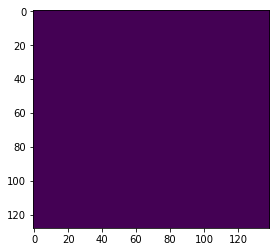

In [9]:
img = np.ones((128,139))
plt.imshow(img)
plt.show()

### start feature selection process

In [10]:
gene = genetic(train,Generation=20,Penalty_rate=1.0)

In [11]:
gene.Generate()

Training Generation 0 is started
Training Generation 0 is Done
Maximum Score Untill Now is 0.3583693019924822 
Best chromosome Untill Now : 
AxesImage(54,36;334.8x217.44)
Training Generation 1 is started
Training Generation 1 is Done
Maximum Score Untill Now is 0.36219145926301227 
Best chromosome Untill Now : 
AxesImage(54,36;334.8x217.44)
Training Generation 2 is started
Training Generation 2 is Done
Maximum Score Untill Now is 0.36219145926301227 
Best chromosome Untill Now : 
AxesImage(54,36;334.8x217.44)
Training Generation 3 is started
Training Generation 3 is Done
Maximum Score Untill Now is 0.36219145926301227 
Best chromosome Untill Now : 
AxesImage(54,36;334.8x217.44)
Training Generation 4 is started
Training Generation 4 is Done
Maximum Score Untill Now is 0.3427862677483272 
Best chromosome Untill Now : 
AxesImage(54,36;334.8x217.44)
Training Generation 5 is started
Training Generation 5 is Done
Maximum Score Untill Now is 0.3538494555862888 
Best chromosome Untill Now : 
A

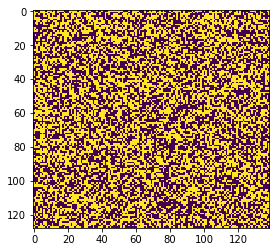

In [12]:
reduced_feature = gene.train()

we save selected feature as mask for future use (black indicates selected feature) 

In [13]:
np.savetxt('feature_mask2.txt',reduced_feature)

final feature count

In [14]:
gene.society[0,0].sum()

8925

save feature which has not been used in training process

In [16]:
pd.DataFrame.to_pickle(test,'test.pkl')

In [17]:
pd.DataFrame.to_pickle(validation,'validation.pkl')